In [18]:
#
from glob import glob as gg
#
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc as rc
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
#
from scipy.io import loadmat
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
#
from netCDF4 import Dataset  
#
from datetime import datetime
from datetime import date
#
import pandas as pd
#
import gsw
#
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,LatitudeLocator)

In [54]:
#
# parameters for the pre-processing step of CTD data sets
#

# data path
path_data = '../../data/'

# CTD (Ben) infos: path and filename
path_CTD_data = path_data + 'ITP_CTD_Ben/'
filename_CTD_data = path_CTD_data + 'mosaic.whoiitpmerged.newgrid.mat'
# selected ITP ('ITP92', 'ITP102', 'ITP111')
ITP_name = 'ITP111'

# Polarstern trajectory infos: path and filename
path_track = path_data + 'TRACK/' 
filename_track = path_track + 'Polarstern_daily_track.nc'

# mesh infos: path and filename
path_mesh = path_data + 'MESH/'
filename_mesh = path_mesh + 'REcoM1D_daily_mesh.nc'

# parameter related to the processing steps
# infos about interpolation and extrapolation of profile data (1st step of processing)
temperature_extrapolation_high_depth_method = 'exponential' # linear or exponential convergence to freezing temperature
# width of the window for the moving average outlier removal (2nd step of processing)
window_width = 5

# output infos: path and filename
path_output = path_data + 'ITP_CTD_Ben/'
filename_output = path_output + 'ITP_daily_data.nc'
flag_smooth_output=True # flag whether to store smooth (moving averaged) salinity/temperature 2D fields or rough processed

In [3]:
#
# load ITP data: dates, coordinates, depth, temperature, salinity
#

# compute depth from pressure using gsw librairy
def compute_depth(pressure, latitude):
    depth = []
    for lat in latitude:
        tmp = gsw.z_from_p(pressure, lat)
        depth.append(gsw.z_from_p(pressure, lat))
    return np.asarray(depth)

# compute daily values of coordinates, temperature and salinity
def compute_daily_values(time, lon, lat, T, S):    
    # remove outliers
    ind=np.where(time>0)[0]
    time, lon, lat = time[ind], lon[ind], lat[ind]
    T, S = T[:,ind], S[:,ind]
    
    # sort dates (daily)
    dates, indices = np.unique(np.floor(time), return_inverse=True)
        
    # compute daily values
    longitude, latitude, temperature, salinity = [], [], [], []
    for i in range(len(dates)):
            index = np.where(indices==i)[0]
            #print (ind)
            # longitude, latitude, temperature, salinity
            tmp1, tmp2 = np.nanmean(lon[index]), np.nanmean(lat[index])
            tmp3, tmp4 = np.nanmean(T[:,index],-1), np.nanmean(S[:,index],-1)
            longitude.append(tmp1), latitude.append(tmp2), temperature.append(tmp3), salinity.append(tmp4)
            
    return dates, np.asarray(longitude), np.asarray(latitude), np.asarray(temperature), np.asarray(salinity)

# ITP data
class ITP_daily_data:
    def __init__(self,filename, ITP_name):
        self.estimate_daily_ITP_variables(filename, ITP_name)
        
    def estimate_daily_ITP_variables(self, filename, ITP_name):
        ## 1. load ITP data
        # define data index according to ITP_name
        if 'ITP92' in ITP_name:
            ind = 0
        elif 'ITP101' in ITP_name:
            ind = 1
        elif 'ITP111' in ITP_name:
            ind=-1
            
        # load data
        matdata = loadmat(filename)
        # dates (time axis)
        dates = matdata['julds'][:,ind]-366.
        
        # coordinates
        longitude, latitude = matdata['lons'][:,ind], matdata['lats'][:,ind]
        
        # salinity amd temperature
        salinity, temperature = matdata['salg'][:,:,ind],matdata['ptmpg'][:,:,ind]

        ## 2. compute daily values
        days, lon, lat, temp, sal = compute_daily_values(dates, longitude, latitude, temperature, salinity)
        
        ## 3. compute depth axis from pressureh
        depth = compute_depth(matdata['pressg'][0], lat)
        
        ## 4. store data
        self.dates, self.longitude, self.latitude = days, lon, lat 
        self.depth, self.temperature, self.salinity = depth, temp, sal
#
# load data
#
ITP_data =  ITP_daily_data(filename_CTD_data, ITP_name)

/tmp/ipykernel_28528/476765329.py:30: RuntimeWarning: Mean of empty slice
  tmp3, tmp4 = np.nanmean(T[:,index],-1), np.nanmean(S[:,index],-1)


In [4]:
#
# load Polarstern daily trajectory 
#
class Trajectory_Polarstern:
    def __init__(self, filename):
        self.read_trajectory(filename)

    def read_trajectory(self, filename):
        ncid = Dataset(filename, "r", format="NETCDF4")
        self.dates = ncid['dates'][:]
        self.longitude, self.latitude = ncid['longitude'][:], ncid['latitude'][:]
        ncid.close()
#
# load MOSAiC trajectory
#
trajectory = Trajectory_Polarstern(filename_track)

In [5]:
#
# load daily mesh data
#
class mesh_data:
    def __init__(self, filename):
        self.read_vertical_mesh(filename)
        
    def read_vertical_mesh(self,filename):
        ncid = Dataset(filename, "r", format="NETCDF4")        
        
        # read dates 
        self.dates = ncid.variables['dates'][:]
        
        # read vertical mesh
        self.nlevels, self.Z = ncid.variables['nlevels'][:]-1, ncid.variables['Z'][:]
        ncid.close()
#
# read mesh information
#
mesh = mesh_data(filename_mesh)

/tmp/ipykernel_28528/2533354098.py:47: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  ax[0].pcolor(D-date_ref, data.depth, data.temperature)
/tmp/ipykernel_28528/2533354098.py:53: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  ax[1].pcolor(D-date_ref, data.depth, data.salinity)


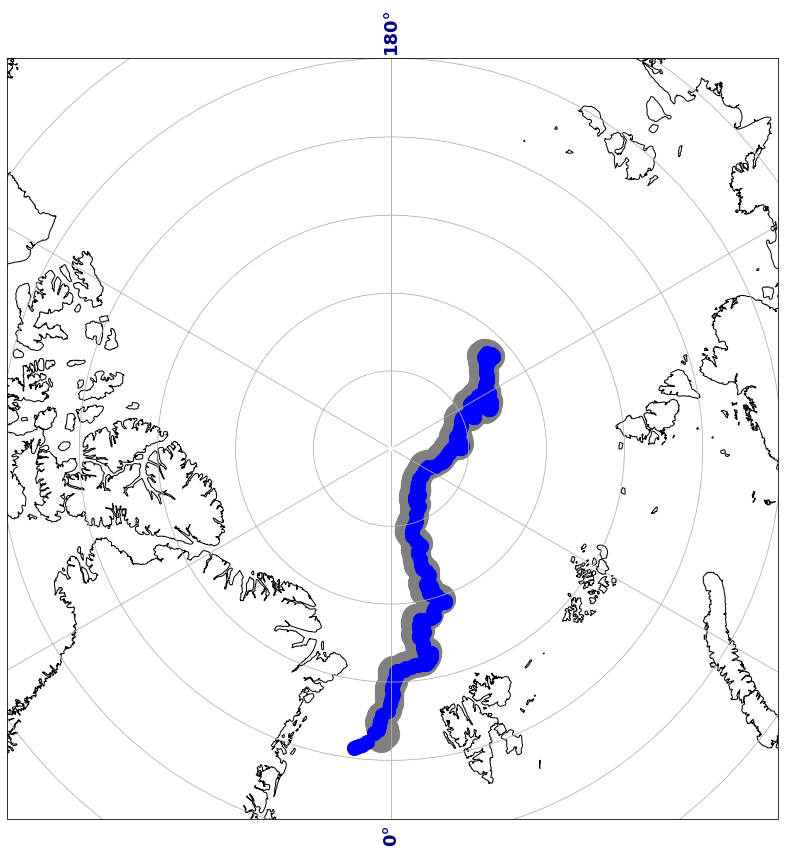

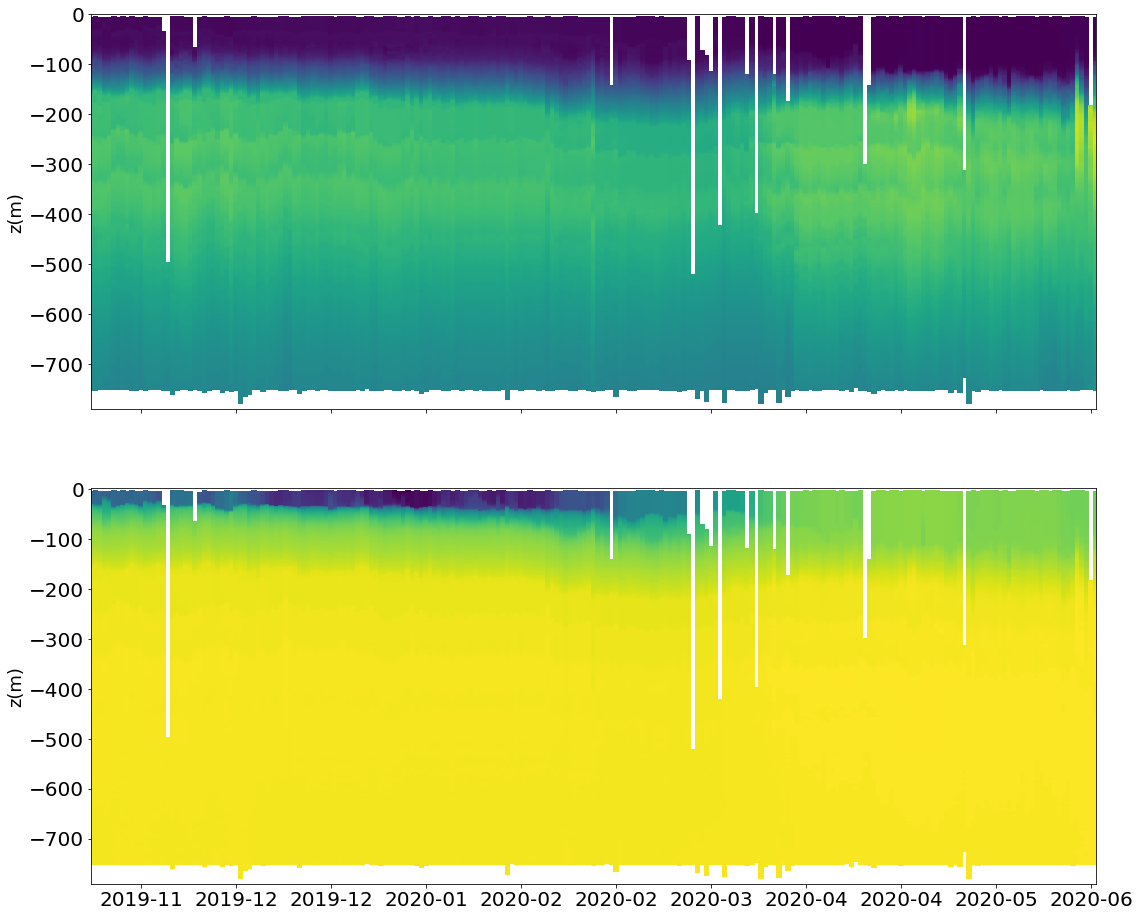

In [37]:
#
# Plot data for verification/visualization (track, 2D salinity/temperature)
#

# define Arctic map
def define_map():
    fig = plt.figure(figsize=(14, 14))
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    ax.coastlines(resolution='10m');
    #ax.stock_img()
    gl=ax.gridlines(draw_labels=True, dms=False)
    gl.xlabel_style = {'color': 'navy', 'weight': 'bold', 'size': 18}
    gl.ylabel_style = {'color': 'gainsboro', 'weight': 'bold', 'size': 18}
    gl.ylabel_style = {'color': 'gainsboro', 'weight': 'bold', 'size': 0}
    gl.ylocator = LatitudeLocator()
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    return(fig, ax)

# plot map
def plot_sensor_map(trajectory, data):
    Proj = ccrs.PlateCarree()
    fig, ax = define_map()
    plot_extent = [-180, 180, 75, 90]
    ax.set_extent(plot_extent, crs=Proj)
    lbsz, tcsz, mksz = 30, 20, 20
    rc('xtick', labelsize=tcsz) , rc('ytick', labelsize=tcsz)
    # trajectory of the Polarstern
    var=trajectory
    ax.scatter(var.longitude, var.latitude, c='0.5', s=800, transform=Proj)
    # trajectory of the sensor
    var=data
    ax.scatter(var.longitude, var.latitude, c='b', s=200, transform=Proj)
    
def plot_variables(data):
    date_ref = datetime.strptime('1970-01-01','%Y-%m-%d').toordinal()
    fsz, tl = (18,16), [np.min(mesh.dates)-date_ref, np.max(mesh.dates)-date_ref]

    fig,ax = plt.subplots(2, sharex=True, figsize=fsz)
    # temperature
    Dstr, D, nt, npd =np.zeros(data.temperature.shape).astype(str), np.zeros(data.temperature.shape), len(data.dates), data.temperature.shape[1]
    for i in range(npd):
        for j,dt in enumerate(data.dates):
            D[j,i]= dt
            Dstr[j,i] = datetime.strftime(datetime.fromordinal(int(dt)), '%Y-%m-%d')
    #print (D, D-date_ref)
    ax[0].pcolor(D-date_ref, data.depth, data.temperature)
    ax[0].axvline(x=737587)
    ax[0].set_xlim(tl)
    ax[0].set_ylabel('z(m)', fontsize=18)
    
    # salinity
    ax[1].pcolor(D-date_ref, data.depth, data.salinity)
    ax[1].set_xlim(tl)
    ax[1].set_ylabel('z(m)', fontsize=18)

    ax[1].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    ax[1].xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    
def plot_sensor_data(trajectory, data):
    # plot drift map
    plot_sensor_map(trajectory, data)
    
    # plot temperature and salinity
    plot_variables(data)
#
#
# plot sensor trajectory and salinity/temperature raw signal
plot_sensor_data(trajectory, ITP_data)

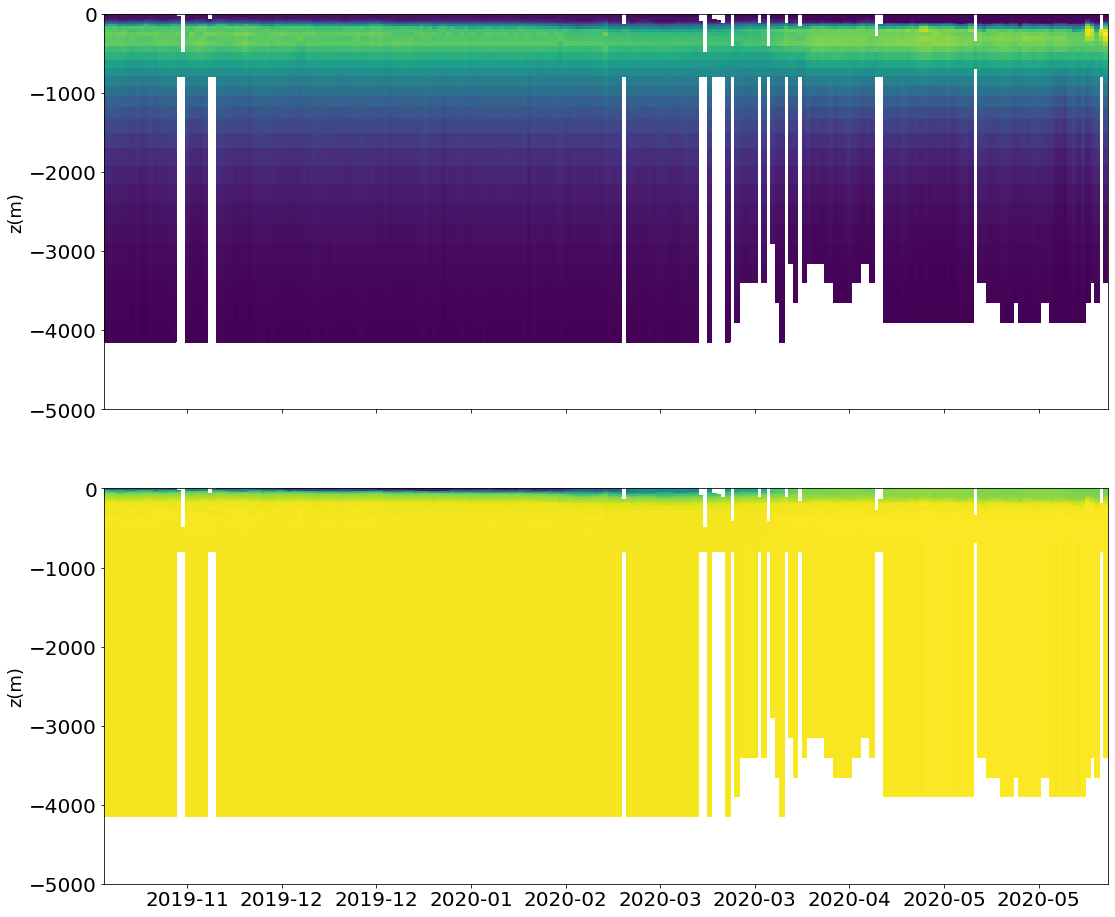

In [43]:
#
# 1st processing step:
# functions to extrapolate ITP salinity and temperature profiles to the surface and high depth 
#

# 1. salinity
# extend salinity profile to the surface (constant near the surface)
def extrapolate_salinity_surface(inp):
    outp = np.copy(inp)
    ind = np.where(np.isnan(outp[:10]))[0]
    #extend linearly to the surface
    outp[ind] = 2*outp[ind+1] - outp[ind+2]
    return outp

# extend salinity to high depth (constant deeper)   
def extrapolate_salinity_high_depth(inp):
    outp = np.copy(inp)
    ind = np.where(np.isnan(outp))[0]
    sp = outp[ind[0]-1]
    outp[ind] = sp
    
    return outp

# 2. temperature
# extend temperature profile linearly to the surface
def extrapolate_temperature_surface(inp):
    outp = np.copy(inp)
    ind = np.where(np.isnan(outp[:10]))[0]
    if len(ind)<2:
                #extend linearly to the surface
                outp[ind] = outp[ind+1]
    return outp
# extend temperature profile to high depth either linearly or with an exponential convergence to the freezing temperature
def extrapolate_temperature_high_depth(inp,method, depth=[], D=[], T=[], tmin=[], Tf=[], zref=-500):
    outp = np.copy(inp)
    thr=1e-5
    ind = np.where(np.isnan(inp[:]))[0]
    if method=='linear':
        for i in ind:
            outp[i] = 2*outp[i-1] - outp[i-2]
            
    elif method=='exponential':

        # computation indices indices 
        # data
        ind, indnan = np.where(D<zref)[0], np.where(~np.isnan(T))[0]
        indices = list(set(ind) & set(indnan)) 
        x1, y1 = abs(D[indices]), T[indices]
        # gridded
        index = np.where(depth<zref)[0]
        x2 = abs(depth[index]) 
        # exponential decay to be fitted
        def func(x,a):
            y = tmin - (tmin-Tf) *(1- np.exp(-a*(x-x1[0])))
            return y
        
        # fit function to data
        popt, pcov = curve_fit(func, x1, y1)
        y2 = func(x2,*popt)
        #store data
        outp[index] = y2
        
    return outp
# compute freezing temperature according to salinity profiles
def compute_freezing_temperature(salinity):
    a = -18.48
    b = -a/1000.
    
    Tf = salinity/(a + b * salinity)
    
    return Tf

# plot_map
def plot_variables_map(var):
    fsz = (18,16)
    dl = [-5000, 0]
    date_ref = datetime.strptime('1970-01-01','%Y-%m-%d').toordinal()
    fig,ax = plt.subplots(2, sharex=True, figsize=fsz)

    # temperature
    ax[0].pcolor(var.dates-date_ref, var.depth, var.temperature.T)
    #ax[0].pcolor(var.temperature)
    ax[0].set_ylim(dl), ax[0].set_ylabel('z(m)', fontsize=18)
    
    # salinity
    ax[1].pcolor(var.dates-date_ref, var.depth, var.salinity.T)
    #ax[1].pcolor(var.salinity.T)
    #ax[1].set_xlim(tl)
    ax[1].set_ylim(dl), ax[1].set_ylabel('z(m)', fontsize=18)
    
    ax[1].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    ax[1].xaxis.set_major_formatter(DateFormatter("%Y-%m"))
# 
# perform vertical interpolation and extrapolation
#
class vertical_interpolation:
    def __init__(self, data, mesh):
        self.perform_vertical_interpolation(data, mesh)
        
    def perform_vertical_interpolation(self,data, mesh):
        # initialization
        self.dates, self.depth = mesh.dates, mesh.Z
        nt, nz = len(mesh.dates), len(mesh.Z)
        temperature, salinity = np.zeros((nt,nz))*np.nan, np.zeros((nt,nz))*np.nan
        indsal, indtemp = [], []
        # vertical interpolation according to bathymetry
        dat = mesh.dates
        
        # process the different ITP profiles separately
        for i, dt in enumerate(dat):
            # A. initialization
            # vertical level
            nl = int(mesh.nlevels[i])
            Z = [z for z in mesh.Z[:nl]]
            
            # find corresponding time in data
            indt = np.where(abs(data.dates-dt)<1e-3)[0]
            datad, datas, datat = data.depth[indt][0], data.salinity[indt][0], data.temperature[indt][0]
            
            # B. perform rough interpolation of the salinity/temperature profile
            # perform interpolation
            # salinity
            f=interp1d(datad, datas, fill_value='extrapolate')
            sal = f(Z)
            # temperature
            f=interp1d(datad,datat, fill_value='extrapolate')
            temp=f(Z)
    
            # C. extend salinity profile to the surface and in high depth
            # process gap in salinity
            # idea: - interpolate on the 1st meters
            #       - extend linearly (same value) in high depth
            #       - test if data are sufficient in the profile 
            #         otherwise leave NaN that will be interpolated temporally
            # extend linearly to the surface
            ind = np.where(np.isnan(sal[:10]))[0]
            if len(ind)<2:
                #extend linearly to the surface
                sal = extrapolate_salinity_surface(sal)
                
                # extend linearly to high depth
                sal = extrapolate_salinity_high_depth(sal)

            else:
                indsal.append(i)


            
            # D. extend salinity profile to the surface and in high depth
            # process gap in temperature
            # idea : - extend linearly in the first meters
            #        - extend in high depth either linearly or with an exponential convergence to freezing temperature
            #
            # estimate freezing temperature from salinity
            Tf = compute_freezing_temperature(sal[-1])
            ind = np.where(np.isnan(temp[:10]))[0]
            
            if len(ind)<2:
                dref = - 500
                #extend linearly to the surface
                temp = extrapolate_temperature_surface(temp)
                # extend linearly to high depth
                #temp = extrapolate_temperature_high_depth(temp,'linear')
                tmin = datat[np.where(datad<=dref)[0][0]]
                temp = extrapolate_temperature_high_depth(temp, temperature_extrapolation_high_depth_method, self.depth[:nl], datad, datat, tmin, Tf, dref)
                
            else:
                indtemp.append(i)
           
            # store data
            salinity[i,:nl], temperature[i,:nl] = sal, temp
            
        self.salinity, self.temperature = salinity, temperature
        self.indtemp, self.indsal = indtemp, indsal
#
# extend ITP salinity/temperature profiles to the surface and high depth
#
ITP_data_processed_1st_step = vertical_interpolation(ITP_data,mesh)

#
# plot 2D salinity/temperature field that are resulting from this extrapolation processing
#
plot_variables_map(ITP_data_processed_1st_step)

/tmp/ipykernel_28528/2371170404.py:15: RuntimeWarning: Mean of empty slice
  mvar = np.nanmean(var[jind,:],0)


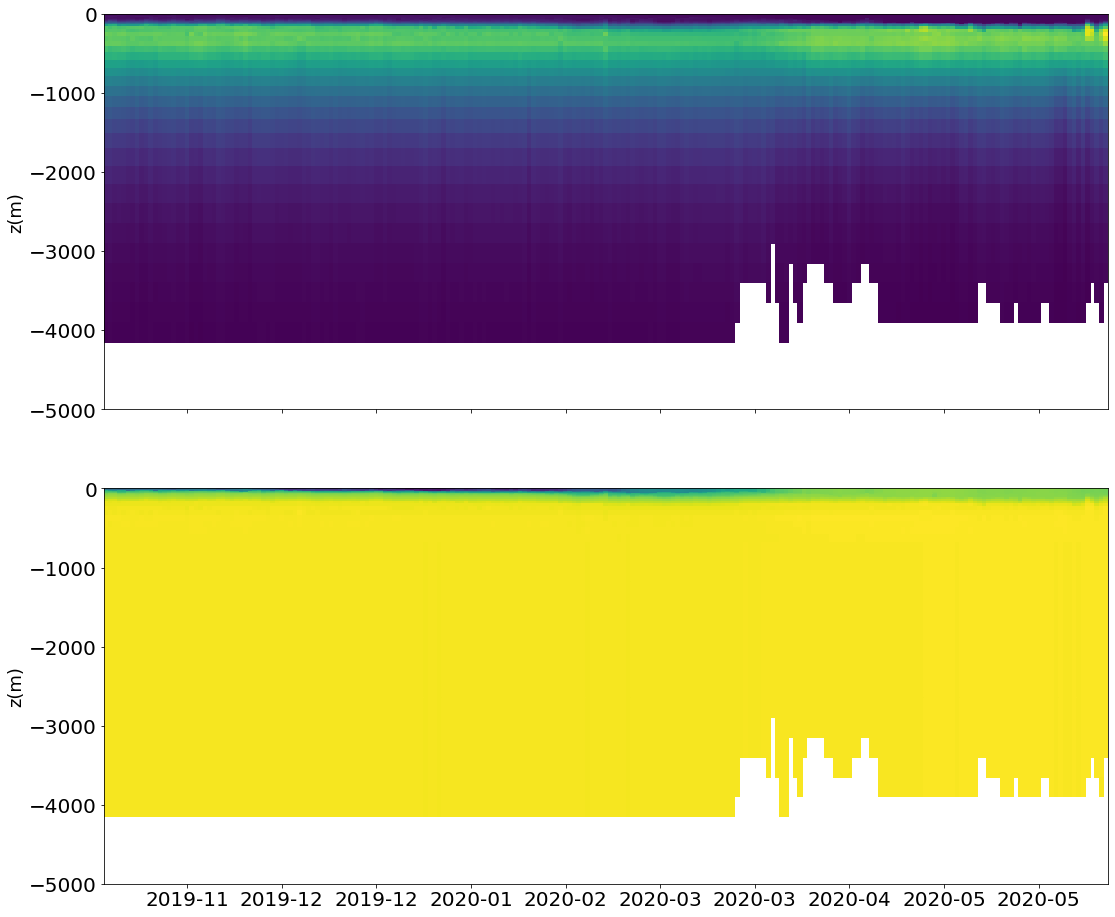

In [45]:
#
# 2nd processing step:
# perform a temporal moving average in the vicinity of the outlier profile to estimate a mean profile at this location

def outlier_moving_average(dates, var, mesh, indices, width):
    
    # initialization
    output = np.copy(var)
    nt = len(dates)
    
    for i in indices:
        # compute moving average in temporal window
        ind1, ind2 = np.max([0, i-width]), np.min([i+width,nt-1])
        jind = np.linspace(ind1,ind2, ind2-ind1+1).astype(int)
        mvar = np.nanmean(var[jind,:],0)
        # compute outlier profile as the mean of the window
        output[i,:] = mvar
        # mask on bottom mesh levels (not accounted for in the computation)
        nlvl = int(mesh.nlevels[i])
        output[i,nlvl+1:] = np.nan
    return output


# process salinity  and temperature outliers
# idea : temporal moving average on a given window
class temporal_moving_average:
    def __init__(self, data, mesh, width):
        self.dates, self.depth, self.nlevels = data.dates, data.depth, mesh.nlevels
        
        self.salinity, self.temperature = np.copy(data.salinity), np.copy(data.temperature)
        
        self.perform_temporal_moving_average(data, mesh, width)
        
    def perform_temporal_moving_average(self, var, mesh, width):
        
        # salinity
        self.salinity = outlier_moving_average(var.dates, var.salinity, mesh, var.indsal, width)
        
        # temperature
        self.temperature = outlier_moving_average(var.dates, var.temperature, mesh, var.indtemp, width)
        
#
ITP_data_processed_2nd_step = temporal_moving_average(ITP_data_processed_1st_step, mesh, window_width)
plot_variables_map(ITP_data_processed_2nd_step)

(223, 47)


/tmp/ipykernel_28528/3182020712.py:12: RuntimeWarning: Mean of empty slice
  average[i]=np.nanmean(array[ind1:ind2+1])


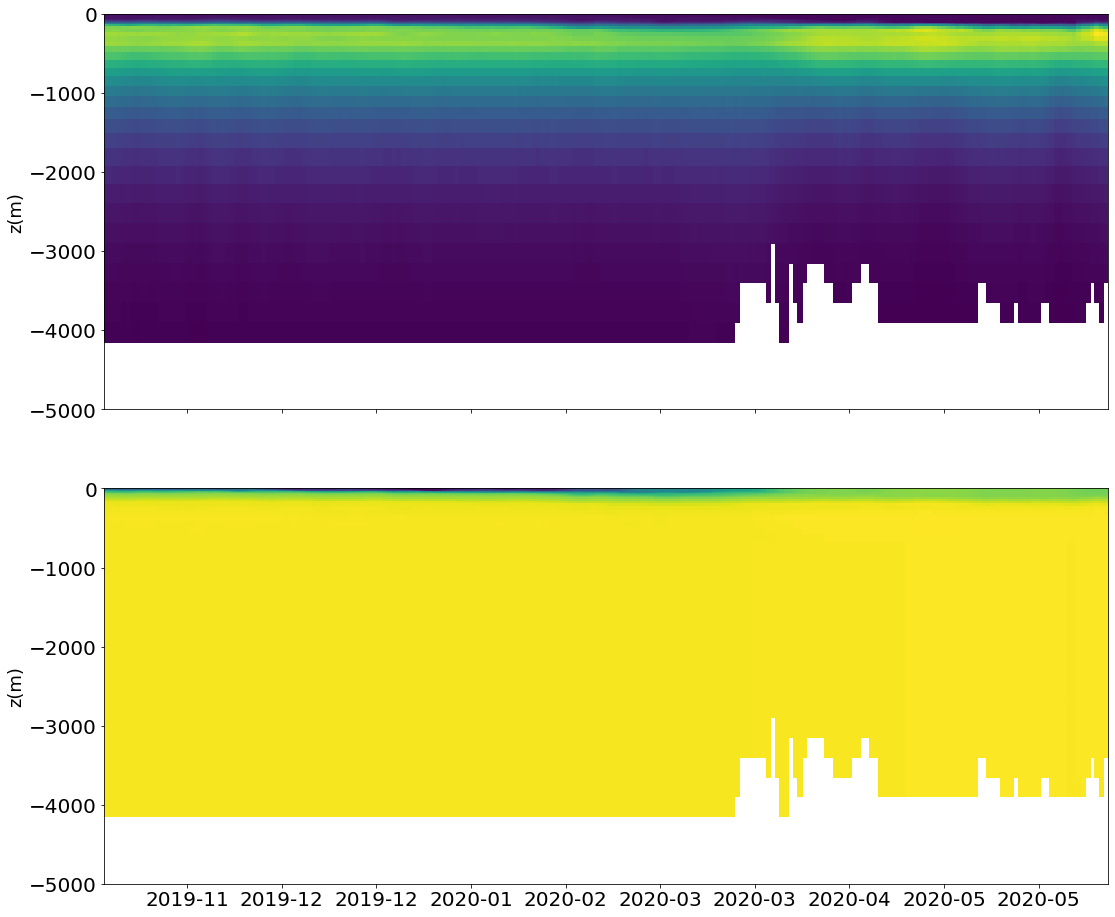

In [50]:
#
# 3rd processing step:
# perform a temporal moving average accounting for all profiles to smooth the temporal variablility

def moving_average_filter(array, window_width):
    # temporal moving average per depth level
    nx=len(array)
    radius=int(np.floor(window_width/2))
    average = np.zeros(len(array))
    for i in range(nx):
        ind1, ind2 = np.max([0,i-radius]), np.min([i+radius,nx-1])
        average[i]=np.nanmean(array[ind1:ind2+1])
    
    return average

class temporal_moving_average:
    def __init__(self, data, width):
        self.dates, self.depth, self.nlevels = data.dates, data.depth, data.nlevels
        
        self.perform_moving_average(data,width)
        
    def perform_moving_average(self,data, width):
        # initialization
        temp, sal = np.zeros(data.salinity.shape), np.zeros(data.temperature.shape)
        print(temp.shape)
        nlvl = len(data.depth)
        
        # perform moving average on each level (salinity, temperature)
        for i in range(nlvl):
                # salinity
                S = data.salinity[:,i]
                index = np.where(np.isnan(S))[0]
                S = moving_average_filter(S, width)
                sal[:,i] = S 
                if len(index)>0:
                    sal[index,i] = np.nan
                    
                # temperature
                T = data.temperature[:,i]
                index = np.where(np.isnan(T))[0]
                T = moving_average_filter(T, width)
                temp[:,i] = T 
                if len(index)>0:
                    temp[index,i] = np.nan
        self.temperature, self.salinity = temp, sal
        
#
ITP_data_processed_3rd_step = temporal_moving_average(ITP_data_processed_2nd_step, window_width)
plot_variables_map(ITP_data_processed_3rd_step)

In [55]:
class Output(object):
    def __init__(self, filename, data):
        self.write_ocn_forcing(filename, data)
    
    def write_ocn_forcing(self,filename, data):
        #------------------------------------------------------------------------
        # write ITP salinity and temperature profile to netcdf
        #------------------------------------------------------------------------	
    
        # open file
        ncid = Dataset(filename, "w", format="NETCDF4")

        # define dimension
        nt, nlvl = len(data.dates), len(data.depth)
    
        ncid.createDimension('time', nt)
        ncid.createDimension('levels', nlvl)
        dimt, dimlvl, dim = ('time'), ('levels'), ('levels','time') 
        
        # create variable
        dat = ncid.createVariable('dates', "f8", dimt)
        D, nlev = ncid.createVariable('depth', "f8",dimlvl), ncid.createVariable('nlevels', "f8",dimt)
        sal, temp = ncid.createVariable('salinity', "f8",dim), ncid.createVariable('temperature', "f8",dim)

        
        # define units
        dat.units, dat.description = 'days', 'days since '+ str(datetime.fromordinal(int(data.dates[0])))
        D.units, nlev.units = 'm', ''
        sal.units, temp.units = 'PSU', 'degC' 
        sal.long_name, temp.long_name = 'practical salinity', 'potential temperature'
        #fill variables
        ncid['dates'][:] = data.dates
        ncid['depth'][:], ncid['nlevels'][:] = data.depth, data.nlevels 
        ncid['salinity'][:], ncid['temperature'][:] = data.salinity.T, data.temperature.T
   
        # close file
        ncid.close()
#
# write to data to netcdf
#
data = ITP_data_processed_3rd_step if flag_smooth_output else ITP_data_processed_2nd_step
Output(filename_output, data)